In [212]:
import pandas as pd
import numpy as np

In [477]:
df_rec = pd.read_csv('recom.csv')

>Preprocessing

1. Looked for any non traditional transaction id
2. Some values are missing on ItemKey column. CodeProduct and itemKey columns includes same information. Fill ItemKey NaN with Code_Product 
3. Droped Code_Product and Unnamed: 0 colums.

In [478]:
df_rec.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      50000 non-null  int64  
 1   Main_ID         50000 non-null  object 
 2   Transaction_ID  50000 non-null  object 
 3   Date            50000 non-null  object 
 4   Price           50000 non-null  float64
 5   Code_Product    50000 non-null  float64
 6   Amount          50000 non-null  float64
 7   ItemKey         28597 non-null  float64
dtypes: float64(4), int64(1), object(3)
memory usage: 3.1+ MB


In [479]:
df_rec[df_rec['Transaction_ID'].str.len() <5]

,Unnamed: 0,Main_ID,Transaction_ID,Date,Price,Code_Product,Amount,ItemKey


In [480]:
df_rec_code_item = df_rec[df_rec['Code_Product'] != df_rec['ItemKey']]
df_rec_code_item['ItemKey'].nunique()
df_rec['ItemKey'] = df_rec['Code_Product']

In [481]:
df_rec = df_rec.drop(['Code_Product','Unnamed: 0'], axis =1)

In [482]:
df_rec.head()

,Main_ID,Transaction_ID,Date,Price,Amount,ItemKey
0,90fada91,264f7a69,2022-10-07 20:53:49.153,125.0,1.0,5002.0
1,9006f9ac,45c7d853,2022-09-17 15:54:57.187,19.0,1.0,35012.0
2,32270891,61ad76dd,2022-11-28 13:51:55.667,141.0,1.0,5005.0
3,97e03e47,41ee09f6,2022-09-12 16:20:22.110,4.5,1.0,35078.5
4,41949228,244fe6d8,2022-10-14 18:53:43.933,129.5,5.0,49291.5


>End of Preprocessing

> Recommendation System

>1. Non Personalized - Recommend Popular purchased items

In [483]:
popular_items = df_rec['ItemKey'].value_counts()

<AxesSubplot:>

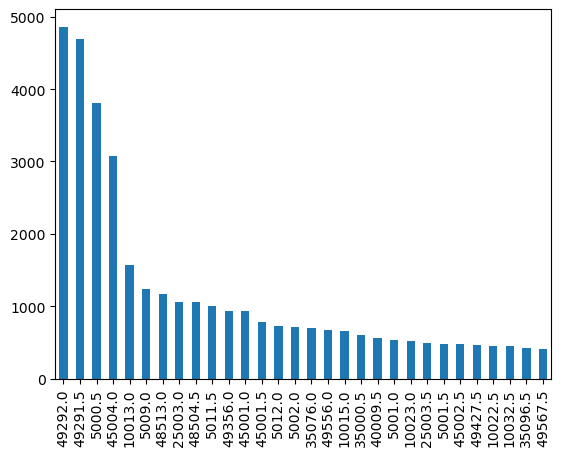

In [484]:
popular_items.head(30).plot(kind='bar')

The above graph gives us the most popular products.

> 2. Build a Rating Column Based on Number of Purchases from the same customer

In [485]:
df_rec.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Main_ID         50000 non-null  object 
 1   Transaction_ID  50000 non-null  object 
 2   Date            50000 non-null  object 
 3   Price           50000 non-null  float64
 4   Amount          50000 non-null  float64
 5   ItemKey         50000 non-null  float64
dtypes: float64(3), object(3)
memory usage: 2.3+ MB


In [486]:
df_rec['cust_rating'] = 0

In [487]:
df_rec_liked = df_rec[df_rec.groupby('Main_ID')['ItemKey'].transform('count') > 1]
df_rec_disliked = df_rec[df_rec.groupby('Main_ID')['ItemKey'].transform('count') == 1]

#For items purchased more than once by the customer,assume they liked it. 
#Rating 0.5: Positive ,Rating 0: Neutral, Rating -0.5: Negative
for i,row in df_rec_liked.iterrows():
    df_rec.iloc[i,6] = 0.5
    
#For items purchased only once by the customer,assume they did not liked it.     
for i,row in df_rec_disliked.iterrows():
    df_rec.iloc[i,6] = -0.5

In [488]:
df_rec

,Main_ID,Transaction_ID,Date,Price,Amount,ItemKey,cust_rating
0,90fada91,264f7a69,2022-10-07 20:53:49.153,125.0,1.0,5002.0,-0.5
1,9006f9ac,45c7d853,2022-09-17 15:54:57.187,19.0,1.0,35012.0,0.5
2,32270891,61ad76dd,2022-11-28 13:51:55.667,141.0,1.0,5005.0,0.5
3,97e03e47,41ee09f6,2022-09-12 16:20:22.110,4.5,1.0,35078.5,-0.5
4,41949228,244fe6d8,2022-10-14 18:53:43.933,129.5,5.0,49291.5,-0.5
...,...,...,...,...,...,...,...
49995,bb127ffb,4e0eb5ab,2022-09-24 21:48:20.847,111.5,4.0,45004.0,0.5
49996,a8bc484a,c9946c16,2022-11-18 19:49:01.973,34.0,1.0,49292.0,-0.5
49997,c983862a,d1a35c5c,2022-11-24 20:02:43.023,178.0,1.0,5001.5,0.5
49998,8821da12,66f9b474,2022-11-06 13:07:01.423,26.0,1.0,49291.5,-0.5


3. Personalized - Recommend items to users based on purchase history and similarity of ratings provided by other users who bought items to that of a particular customer.

In [489]:
df_rec_matrix = df_rec[['Main_ID','ItemKey','cust_rating']].copy()
df_rec_matrix = df_rec_matrix.pivot_table(values ='cust_rating',index = ['Main_ID'], columns ='ItemKey',fill_value=0 )

In [490]:
df_rec_matrix.shape

(28514, 333)

In [491]:
df_rec_matrix_transpose = df_rec_matrix.T
X = df_rec_matrix_transpose
df_rec_matrix_transpose.head()

Main_ID,00024de6,00084856,0008e848,00096930,000c66b7,000e98ee,00165e2e,00171ffd,0019e439,001a93a4,...,ffe473f3,ffe9b45e,ffea59de,ffec4938,fff4483d,fff8b1c4,fff905d0,fff9726b,fffa332b,ffff4aa9
ItemKey,,,,,,,,,,,,,,,,,,,,,
5000.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5001.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5001.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5002.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5002.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [492]:
df_rec_matrix_transpose.shape

(333, 28514)

In [493]:
# I used TruncatedSVD to decrease number of features

In [494]:
from sklearn.decomposition import TruncatedSVD

In [495]:
SVD = TruncatedSVD(n_components = 5, random_state=42)

In [496]:
decomposed_matrix = SVD.fit_transform(X)
decomposed_matrix.shape

(333, 5)

In [497]:
correlation_matrix = np.corrcoef(decomposed_matrix)
correlation_matrix.shape

(333, 333)

In [498]:
df_rec

,Main_ID,Transaction_ID,Date,Price,Amount,ItemKey,cust_rating
0,90fada91,264f7a69,2022-10-07 20:53:49.153,125.0,1.0,5002.0,-0.5
1,9006f9ac,45c7d853,2022-09-17 15:54:57.187,19.0,1.0,35012.0,0.5
2,32270891,61ad76dd,2022-11-28 13:51:55.667,141.0,1.0,5005.0,0.5
3,97e03e47,41ee09f6,2022-09-12 16:20:22.110,4.5,1.0,35078.5,-0.5
4,41949228,244fe6d8,2022-10-14 18:53:43.933,129.5,5.0,49291.5,-0.5
...,...,...,...,...,...,...,...
49995,bb127ffb,4e0eb5ab,2022-09-24 21:48:20.847,111.5,4.0,45004.0,0.5
49996,a8bc484a,c9946c16,2022-11-18 19:49:01.973,34.0,1.0,49292.0,-0.5
49997,c983862a,d1a35c5c,2022-11-24 20:02:43.023,178.0,1.0,5001.5,0.5
49998,8821da12,66f9b474,2022-11-06 13:07:01.423,26.0,1.0,49291.5,-0.5


In [499]:
df_rec_products = df_rec

In [500]:
df_rec_products['Recommended'] = ''

In [501]:
df_rec_products['Recommended'] = pd.to_numeric(df_rec_products['Recommended'],errors ='coerce')

In [502]:
df_rec_products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Main_ID         50000 non-null  object 
 1   Transaction_ID  50000 non-null  object 
 2   Date            50000 non-null  object 
 3   Price           50000 non-null  float64
 4   Amount          50000 non-null  float64
 5   ItemKey         50000 non-null  float64
 6   cust_rating     50000 non-null  float64
 7   Recommended     0 non-null      float64
dtypes: float64(5), object(3)
memory usage: 3.1+ MB


In [503]:
#Recommend each customer product(s) based on their historical purchases

In [504]:
product_names = list(X.index)

for i,row in df_rec_products['ItemKey'].iteritems():
    product_ID = product_names.index(row)
    correlation_product_ID = correlation_matrix[product_ID]
    Recommend = list(X.index[correlation_product_ID > 0.90])
    # Removes the item already bought by the customer if exists
    if i in Recommend:
        Recommend.remove(i) 
    df_rec_products.iloc[i,7] = Recommend[0:1]
                                         

In [505]:
df_rec_products = df_rec_products.groupby('Main_ID')['Recommended'].unique()

In [506]:
df_rec_products = df_rec_products.to_frame()

In [507]:
#Final Customer Based Recommended Product(s)

In [508]:
df_rec_products

,Recommended
Main_ID,
00024de6,[5001.5]
00084856,"[5012.5, 35030.0]"
0008e848,[5001.5]
00096930,[5012.5]
000c66b7,[5001.0]
...,...
fff8b1c4,[5001.5]
fff905d0,[35030.0]
fff9726b,[5001.0]


>4. Non Personalized - Recommend paired purchased items

In [509]:
from itertools import permutations

In [510]:
def create_pairs(X):
    pairs = pd.DataFrame(list(permutations(X.values,2)),columns = ['Item_a','Item_b'])
    return pairs

In [511]:
#Identified paired purchased items

In [512]:
item_pairs = df_rec.groupby('Main_ID')['ItemKey'].apply(create_pairs)

In [513]:
item_pairs.reset_index(drop=True)

,Item_a,Item_b
0,49291.5,49292.0
1,49292.0,49291.5
2,45001.0,5002.0
3,5002.0,45001.0
4,49291.5,49292.0
...,...,...
189359,25003.0,45004.5
189360,45004.5,49292.0
189361,45004.5,25003.0
189362,45001.5,30003.0


In [514]:
#Frequency of Purchased Together Items
pair_counts = item_pairs.groupby(['Item_a','Item_b']).size()
pair_counts_df = pair_counts.to_frame(name='size').reset_index()

#Drop Duplicated pairs
duplicate_pairs = pair_counts_df[pair_counts_df['Item_a'] == pair_counts_df['Item_b']].index
pair_counts_df.drop(duplicate_pairs,inplace = True)

pair_counts_df_sorted = pair_counts_df.sort_values(by='size', ascending = False)

pair_counts_df_sorted

,Item_a,Item_b,size
224,5000.5,49291.5,1287
15026,49291.5,5000.5,1287
15233,49291.5,49292.0,1247
15456,49292.0,49291.5,1247
15248,49292.0,5000.5,1191
...,...,...,...
8471,35011.5,25003.5,1
8472,35011.5,30003.0,1
8473,35011.5,30003.5,1
8475,35011.5,30029.0,1


In [436]:
pair_counts_df_sorted.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16398 entries, 224 to 16531
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Item_a  16398 non-null  float64
 1   Item_b  16398 non-null  float64
 2   size    16398 non-null  int64  
dtypes: float64(2), int64(1)
memory usage: 512.4 KB


In [515]:
df_rec_paired = df_rec
df_rec_paired = df_rec_paired.rename(columns={'Recommended': 'Recommended_Personalized'})
df_rec_paired['Recommended_Paired_Product'] = 0
df_rec_paired.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Main_ID                     50000 non-null  object 
 1   Transaction_ID              50000 non-null  object 
 2   Date                        50000 non-null  object 
 3   Price                       50000 non-null  float64
 4   Amount                      50000 non-null  float64
 5   ItemKey                     50000 non-null  float64
 6   cust_rating                 50000 non-null  float64
 7   Recommended_Personalized    50000 non-null  float64
 8   Recommended_Paired_Product  50000 non-null  int64  
dtypes: float64(5), int64(1), object(3)
memory usage: 3.4+ MB


In [516]:
df_rec_paired.shape

(50000, 9)

In [517]:
pair_counts_df_sorted.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16398 entries, 224 to 16531
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Item_a  16398 non-null  float64
 1   Item_b  16398 non-null  float64
 2   size    16398 non-null  int64  
dtypes: float64(2), int64(1)
memory usage: 512.4 KB


In [518]:
#For each itemkey recommend a paired product
for i,v in df_rec_paired['ItemKey'].iteritems():
    A = pair_counts_df_sorted[(pair_counts_df_sorted.iloc[:,0] == v)]
    if len(A.index)> 0:
        df_rec_paired.iloc[i,8] =A.iloc[0,1]

In [519]:
df_rec_paired

,Main_ID,Transaction_ID,Date,Price,Amount,ItemKey,cust_rating,Recommended_Personalized,Recommended_Paired_Product
0,90fada91,264f7a69,2022-10-07 20:53:49.153,125.0,1.0,5002.0,-0.5,5001.0,5000.5
1,9006f9ac,45c7d853,2022-09-17 15:54:57.187,19.0,1.0,35012.0,0.5,35012.0,49292.0
2,32270891,61ad76dd,2022-11-28 13:51:55.667,141.0,1.0,5005.0,0.5,5001.0,49292.0
3,97e03e47,41ee09f6,2022-09-12 16:20:22.110,4.5,1.0,35078.5,-0.5,5012.5,49292.0
4,41949228,244fe6d8,2022-10-14 18:53:43.933,129.5,5.0,49291.5,-0.5,5012.5,5000.5
...,...,...,...,...,...,...,...,...,...
49995,bb127ffb,4e0eb5ab,2022-09-24 21:48:20.847,111.5,4.0,45004.0,0.5,40064.5,5000.5
49996,a8bc484a,c9946c16,2022-11-18 19:49:01.973,34.0,1.0,49292.0,-0.5,35030.0,49291.5
49997,c983862a,d1a35c5c,2022-11-24 20:02:43.023,178.0,1.0,5001.5,0.5,5001.0,5000.5
49998,8821da12,66f9b474,2022-11-06 13:07:01.423,26.0,1.0,49291.5,-0.5,5012.5,5000.5


>5. Build Apriori Algorithm for Market Basket Analysis
    1. Pre-processing: Encoding all values in the above data frame to 0 and 1.
    2. Discover most-frequently bought together items

In [521]:
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

In [522]:
df_rec.head()

,Main_ID,Transaction_ID,Date,Price,Amount,ItemKey,cust_rating,Recommended
0,90fada91,264f7a69,2022-10-07 20:53:49.153,125.0,1.0,5002.0,-0.5,5001.0
1,9006f9ac,45c7d853,2022-09-17 15:54:57.187,19.0,1.0,35012.0,0.5,35012.0
2,32270891,61ad76dd,2022-11-28 13:51:55.667,141.0,1.0,5005.0,0.5,5001.0
3,97e03e47,41ee09f6,2022-09-12 16:20:22.110,4.5,1.0,35078.5,-0.5,5012.5
4,41949228,244fe6d8,2022-10-14 18:53:43.933,129.5,5.0,49291.5,-0.5,5012.5


In [523]:
#basket = (df_rec.groupby(['Transaction_ID','ItemKey'])['Amount'].sum().unstack().reset_index().fillna(0).set_index('Transaction_ID'))
basket = (df_rec.groupby(['Main_ID','ItemKey'])['Amount'].sum().unstack().reset_index().fillna(0).set_index('Main_ID'))
basket

ItemKey,5000.5,5001.0,5001.5,5002.0,5002.5,5003.0,5004.0,5004.5,5005.0,5007.0,...,200035.5,200037.0,200037.5,200038.0,200038.5,200045.5,200046.0,200046.5,200047.0,350027.5
Main_ID,,,,,,,,,,,,,,,,,,,,,
00024de6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00084856,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0008e848,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00096930,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
000c66b7,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fff8b1c4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
fff905d0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
fff9726b,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [524]:
def encode(freq):
    if freq <= 0: 
        return 0
    if freq >= 1:
       return 1 

basket_encoded = basket.applymap(encode)

In [525]:
basket_encoded.head(20)

ItemKey,5000.5,5001.0,5001.5,5002.0,5002.5,5003.0,5004.0,5004.5,5005.0,5007.0,...,200035.5,200037.0,200037.5,200038.0,200038.5,200045.5,200046.0,200046.5,200047.0,350027.5
Main_ID,,,,,,,,,,,,,,,,,,,,,
00024de6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
00084856,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0008e848,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
00096930,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
000c66b7,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
000e98ee,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
00165e2e,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
00171ffd,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0019e439,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Most of the people bought only one items

In [526]:
frequent_itemsets = apriori(basket_encoded,min_support =0.001, use_colnames = True)

rules = association_rules(frequent_itemsets,metric = "lift",min_threshold = 1)

rules.head()

/Users/kutayaydin/opt/anaconda3/lib/python3.9/site-packages/mlxtend/frequent_patterns/fpcommon.py:111: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(5000.5),(5001.0),0.110788,0.016904,0.005050,0.045584,2.696646,0.003177,1.030050
1,(5001.0),(5000.5),0.016904,0.110788,0.005050,0.298755,2.696646,0.003177,1.268048
2,(5000.5),(5001.5),0.110788,0.016167,0.003612,0.032605,2.016716,0.001821,1.016992
3,(5001.5),(5000.5),0.016167,0.110788,0.003612,0.223427,2.016716,0.001821,1.145047
4,(5000.5),(5002.0),0.110788,0.023147,0.005261,0.047483,2.051426,0.002696,1.025550


In [527]:
rules.sort_values(['support','confidence','lift'],axis =0, ascending = False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
90,(5000.5),(49291.5),0.110788,0.144736,0.016273,0.146882,1.014827,0.000238,1.002515
91,(49291.5),(5000.5),0.144736,0.110788,0.016273,0.112430,1.014827,0.000238,1.001851
730,(45004.0),(49292.0),0.095813,0.149751,0.015010,0.156662,1.046149,0.000662,1.008195
731,(49292.0),(45004.0),0.149751,0.095813,0.015010,0.100234,1.046149,0.000662,1.004914
79,(45004.0),(5000.5),0.095813,0.110788,0.014449,0.150805,1.361210,0.003834,1.047124
...,...,...,...,...,...,...,...,...,...
2286,(49292.0),"(10003.0, 10013.0)",0.149751,0.002209,0.001017,0.006792,3.073886,0.000686,1.004613
2478,(49292.0),"(25003.0, 10015.0)",0.149751,0.002315,0.001017,0.006792,2.934164,0.000670,1.004508
1266,(49292.0),"(5000.5, 10004.0)",0.149751,0.002455,0.001017,0.006792,2.766497,0.000649,1.004366
2315,(49292.0),"(10013.0, 10015.0)",0.149751,0.002490,0.001017,0.006792,2.727532,0.000644,1.004331
